In [1]:
from qutip import *
from numpy import *

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("C:\Users\User\Documents\GitHub/colormap/"))
import colormaps as cmaps


In [3]:
import numpy as np
import scipy.constants as cs
import scipy.special as ss
from matplotlib import pyplot as plt
from matplotlib import cm
from qkit.qkit.gui.notebook.Progress_Bar import Progress_Bar as pb
from scipy.integrate import dblquad
from scipy import integrate

%matplotlib inline

In [4]:
#customized plots:
import matplotlib 
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
matplotlib.rc('text', usetex=True)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (10.0,5.0)
matplotlib.rcParams['savefig.dpi'] = 80
matplotlib.rcParams['legend.shadow'] = True
matplotlib.rcParams['savefig.bbox'] = 'tight'


cmap_virdis = cmaps.viridis.colors


hfont = {'fontname':'Helvetica'}


In [5]:
labelsize = 27
ticksize = 20

In [6]:
mu_0 = cs.mu_0                                     #vacuum susceptiblity
mu_B = cs.physical_constants['Bohr magneton'][0]   #Bohr magneton in SI units
k_b = cs.k                                         #K boltzmann
e = cs.e                                           #electron charge
hbar = cs.hbar
h = cs.h
phi_0 = cs.physical_constants['mag. flux quantum'][0]
Rq = h/e**2.

### qubit specification:

In [7]:
tau_p = 1.0*10**(-9)   #minimal pulse duration 
print 'minimum pulse duration: tau_p = {} ns'.format(tau_p*10**9)

minimum pulse duration: tau_p = 1.0 ns


In [8]:
Echarge = hbar/tau_p
print Echarge/h*10**-9

0.159154943092


In [9]:
C = tau_p*e**2./(2.*hbar)
print 'qubit capacitance: C = {}'.format(C)

qubit capacitance: C = 1.21706740304e-13


In [10]:
Ec = e**2/(2.*C)
deltafcap = Ec/h
print 'qubit frequency shift due to Ec: deltaf = {} MHz'.format(deltafcap/10**6)

qubit frequency shift due to Ec: deltaf = 159.154943092 MHz


### readout resonator:

In [11]:
Tp = 50*10.**(-6)      #relaxation time due to purcell effect

In [12]:
fc = 6.*10**9                 #resonator frequency
kappa = 10*10**6              #resonator decay rate/linewidth
QL = (2.*np.pi*fc)/kappa      #resonator quality factor
print 'resonator decay rate: kappa = {} MHz'.format(kappa*10**-6)
print 'resonator quality factor: QL = {}'.format(QL)

resonator decay rate: kappa = 10.0 MHz
resonator quality factor: QL = 3769.91118431


In [13]:
goD = np.sqrt(1./(Tp*kappa))   #ratio between coupling strength and detuning for a Purcell limited T1
print 'ratio between coupling strength and detuning: g/D = {}'.format(goD)

ratio between coupling strength and detuning: g/D = 0.04472135955


In [14]:
chi = kappa
print 'dispersive shift: chi = {} MHz'.format(chi*10**-6)

dispersive shift: chi = 10.0 MHz


In [15]:
g = kappa/goD  #coupling strength
print 'qubit-resonator coupling strength: g = {} MHz'.format(g*10**-6)

qubit-resonator coupling strength: g = 223.60679775 MHz


In [16]:
DELTA = g/goD
print 'qubit-resonator detuning: DELTA = {} GHz'.format(DELTA*10**-9)

qubit-resonator detuning: DELTA = 5.0 GHz


In [17]:
fq = fc + DELTA
print 'qubit frequency: fq = {} GHz'.format(fq*10**-9) 

qubit frequency: fq = 11.0 GHz


In [18]:
LJ2 = 1./((2.*np.pi*fq)**2.*C) 
print 'qubit inductance: LJ = {} nH'.format(LJ2*10**9)
Ic2 = phi_0/(2.*np.pi*LJ2)
print 'qubit crit. current: Ic = {} nA'.format(Ic2*10**9)

qubit inductance: LJ = 1.7200467944 nH
qubit crit. current: Ic = 191.335478063 nA


In [19]:
EJ2 = phi_0*Ic2/(2.*np.pi)
print 'EJ/hbar = {} GHz'.format(EJ2/hbar*10**-9)
print 'Ec/hbar = {} GHz'.format(Ec/hbar*10**-9)

EJ/hbar = 597.111066168 GHz
Ec/hbar = 1.0 GHz


In [20]:
print 'EJ/h = {} GHz'.format(EJ2/h*10**-9)
print 'Ec/h = {} GHz'.format(Ec/h*10**-9)

EJ/h = 95.0331777555 GHz
Ec/h = 0.159154943092 GHz


In [21]:
print 'EJ/Ec = {}'.format(EJ2/Ec)

EJ/Ec = 597.111066168


### Concentric Transmon:

In [22]:
EJcT = 45*10**9.   #divided by h
ELcT = 128*10**9.  #divided by h
ELtot = (1/EJcT + 1/ELcT)**-1               #total inductive energy
ECcT = 0.24*10**9. #divided by h
fcT01 = (np.sqrt(8.*(ELtot)*ECcT)-ECcT)
print 'qubit res. freq.: f01 = {}'.format(fcT01*10**-9)

qubit res. freq.: f01 = 7.75537438527


In [23]:
print 'energy scale: EJ / EC = {}'.format(EJcT/ECcT)

energy scale: EJ / EC = 187.5


In [24]:
IccT = 90.*10**-9

In [25]:
CcT = 81*10**-15

### Eigenenergies:

In [26]:
def k(m,ng):
    '''k-indexnecessary to calculate the transmon eigenenergies in phase basis'''
    k = 0.
    k_array = []
    l = [+1,-1]
    try:
        for j in ng:
            k = 0
            for i in l:
                k += (np.mod(int(2.*j+i/2.),2))*(int(j)+i*(-1)**m*(int((m+1.)/2.)))
            k_array.append(k)
        return k_array
    except:
        for i in l:
            k += (np.mod(int(2.*ng+i/2.),2))*(int(ng)+i*(-1)**m*(int((m+1.)/2.)))
        return k

In [27]:
def Em(m,ng, Ec, EJ):
    '''Transmon eigenenergies in the phase basis;
    Mathieu function returns nan for negative index v (-> absolute value)'''
    E_array = []
    try:
        for i in ng:
            v = 2.*(i+k(m,i))
            E_array.append(Ec*ss.mathieu_a(v,-2.*EJ/(Ec)))
        return np.array(E_array)
    except:
        v = 2.*(ng+k(m,ng))
        return Ec*ss.mathieu_a(v,-EJ/(2.*Ec))

In [28]:
EJ = 20*Ec

In [29]:
Em(1,5.1,Ec,EJ)

nan

In [30]:
ng = np.linspace(-2.,2.,100)

In [31]:
#Em(1,ng, Ec, EJ)

In [32]:
def EmTM(m, Ec,EJ):
    '''engery of the mth Transmon state (approximation for small phase differences across the junction)'''
    return -EJ+np.sqrt(8.*EJ*Ec)*(m+0.5)-Ec*(6.*m**2.+6*m+3.)/12

In [33]:
def DeltaEm(m, EJEC):
    '''energy difference between the mth level and the ground state
    normalized to the charging energy Ec'''
    return (np.sqrt(8.*EJEC)*m-(6.*m**2.+6.*m)/12.)

In [34]:
EmTM(1,Ec,EJ)

-2.4005576852153331e-25

In [35]:
EmTM(3,Ec,EJ)/EmTM(1,Ec,EJ)

-7.917066183465634

In [36]:
EJEC = np.linspace(0,140,1000)

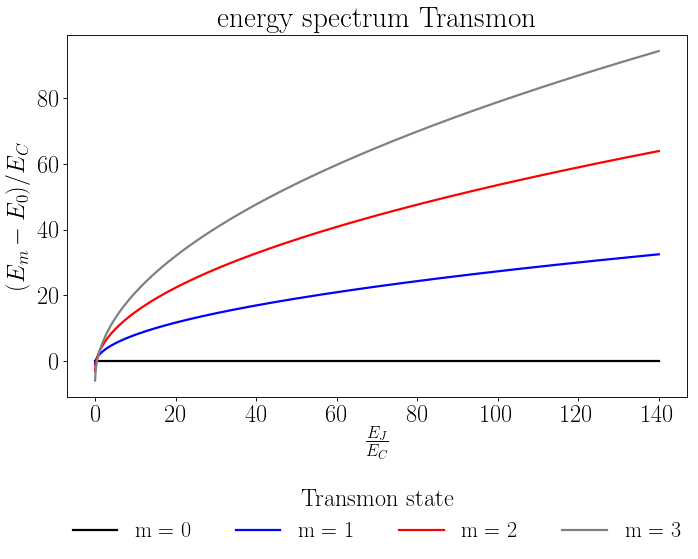

In [37]:
fig_Em, ax = plt.subplots(figsize =(10,6))
ax.set_xlabel(r'$\frac{E_J}{E_C}$')
ax.set_ylabel(r'$(E_m - E_0)/E_C$')
ax.set_title(r'energy spectrum Transmon')
ax.plot(EJEC, DeltaEm(0,EJEC), label = 'm = 0', color = 'black', lw = 2)
ax.plot(EJEC, DeltaEm(1,EJEC), label = 'm = 1', color = 'blue', lw = 2)
ax.plot(EJEC, DeltaEm(2,EJEC), label = 'm = 2', color = 'red', lw = 2)
ax.plot(EJEC, DeltaEm(3,EJEC), label = 'm = 3', color = 'grey', lw = 2)
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5,-0.2), ncol = 4, fontsize =20, frameon = False, title = 'Transmon state')


## Kerr effect and self-Kerr:

In [38]:
def K11(a,l,Ec):
    '''self-Kerr for the fundamental mode of a granular aluminum resonator
    omega: resonance frequency
    a: approximately grain size
    l: length
    Ic: critical current of a single junction'''
    return -3.*np.pi*a**2.*Ec/(4.*l**2.*hbar)

In [39]:
def selfK(a,l,Ec):
    '''Self Kerr calculated with an Junction array shunted by 
    a large capacitance'''
    return -2*a**2.*Ec/(3.*l**2.*hbar)

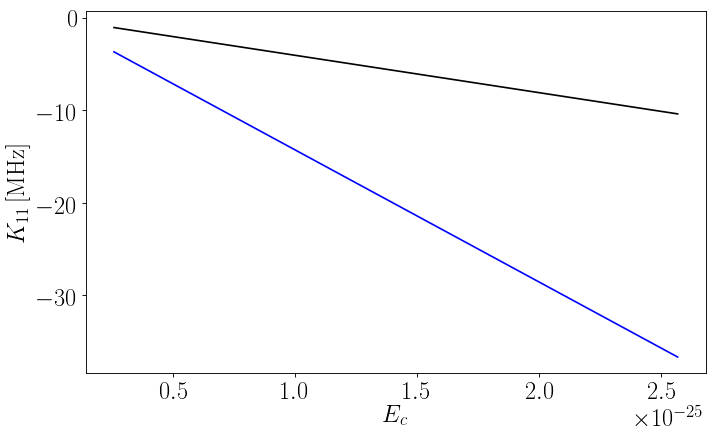

In [40]:
a = 4.*10**-9 #grainsize
l = 50.*10**-9 #GraAl length
C1 = 500*10**-15.
C2 = 50*10**-15.
Ec1 = e**2/(2.*C1)
Ec2 = e**2./(2.*C2)
Ecc = np.linspace(Ec1,Ec2, 100)
figKerr, ax = plt.subplots(figsize = (10,6))
ax.set_ylabel(r'$K_{11}\,\mathrm{[MHz]}$')
ax.set_xlabel(r'$E_c$')
ax.plot(Ecc, selfK(a,l,Ecc)/10**6, color = 'black')
ax.plot(Ecc, K11(a,l,Ecc)/10**6, color = 'blue')

### kinetic sheet inductance

In [41]:
def Lsq(Rsq,Delta):
    '''kinetic inductance per square as a function of
    Rsq: sheet resistance
    Delta: superconducting gap parameter
    Delta (T = 0) = 1.76*kb*Tc'''
    return Rsq*h/(2.*np.pi**2.*Delta)

In [42]:
Rsq = 2000 #sheet resistance in Ohms
Tc = 1.8   #critical temperature in Kelvin
Delta = 1.76*k_b*Tc
L1 = Lsq(Rsq, Delta )

In [43]:
print 'kinetic inductance per Square: L1 (Rsq = {} Ohms) = {} nH'.format(Rsq,L1*10**9)

kinetic inductance per Square: L1 (Rsq = 2000 Ohms) = 1.53492787173 nH


In [44]:
Rsqx = np.linspace(500,3000,200)

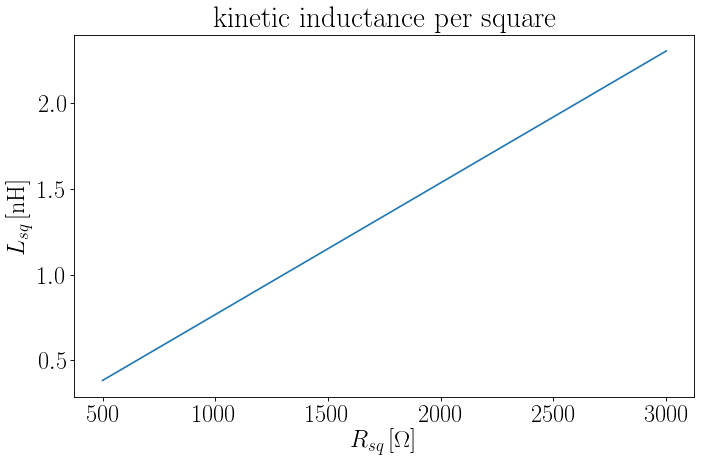

In [45]:
figLsq, axes = plt.subplots(figsize = (10,6))
axes.plot(Rsqx, Lsq(Rsqx, Delta)*10**9)
axes.set_xlabel(r'$R_{sq}\,\mathrm{[\Omega]}$')
axes.set_ylabel(r'$L_{sq}\,\mathrm{[nH]}$')
axes.set_title(r'kinetic inductance per square')

In [46]:
#figLsq.savefig('Lsq_Rsq.png', dpi = 200., bbox_to_anchor = 'tight')

## Charge Qubit energy spectrum

In [47]:
def hamiltonian(Ec, Ej, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (arange(-N,N+1)-ng)**2) + 0.5 * Ej * (np.diag(-np.ones(2*N), 1) + 
                                                               np.diag(-np.ones(2*N), -1))
    return Qobj(m)

In [48]:


def plot_energies(ng_vec, energies, ymax=(20, 3)):
    """
    Plot energy levels as a function of bias parameter ng_vec.
    """
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    for n in range(len(energies[0,:])):
        axes[0].plot(ng_vec, energies[:,n])
    axes[0].set_ylim(np.min(energies[:,0]), ymax[0])
    axes[0].set_xlabel(r'$n_g$', fontsize=labelsize)
    axes[0].set_ylabel(r'$E_n$', fontsize=labelsize)
    axes[0].tick_params(labelsize = ticksize)

    for n in range(len(energies[0,:])):
        axes[1].plot(ng_vec, (energies[:,n]-energies[:,0])/(energies[:,1]-energies[:,0]))
    axes[1].set_ylim(-0.1, ymax[1])
    axes[1].set_xlabel(r'$n_g$', fontsize=labelsize)
    axes[1].set_ylabel(r'$(E_n-E_0)/(E_1-E_0)$', fontsize=labelsize)
    axes[1].tick_params(labelsize = ticksize)
    return fig, axes



In [49]:
N = 10
ng = 0.5

In [50]:
print 'Qubit capacitance: Cq = {} fF'.format(e**2./(2.*Ec)*10**15)

Qubit capacitance: Cq = 121.706740304 fF


In [51]:
EJ = 20.*Ec

In [52]:
#offset charge
ng_vec = np.linspace(-1, 1, 200)

### Early Transmon regime

In [53]:
energies = array([hamiltonian(Ec,EJ,N,ng).eigenenergies() for ng in ng_vec])

In [54]:
print 'e_min (EJ = {}) = {}'.format(EJ, np.min(energies[:,0]))

e_min (EJ = 2.10914360028e-24) = -1.46975460414e-24


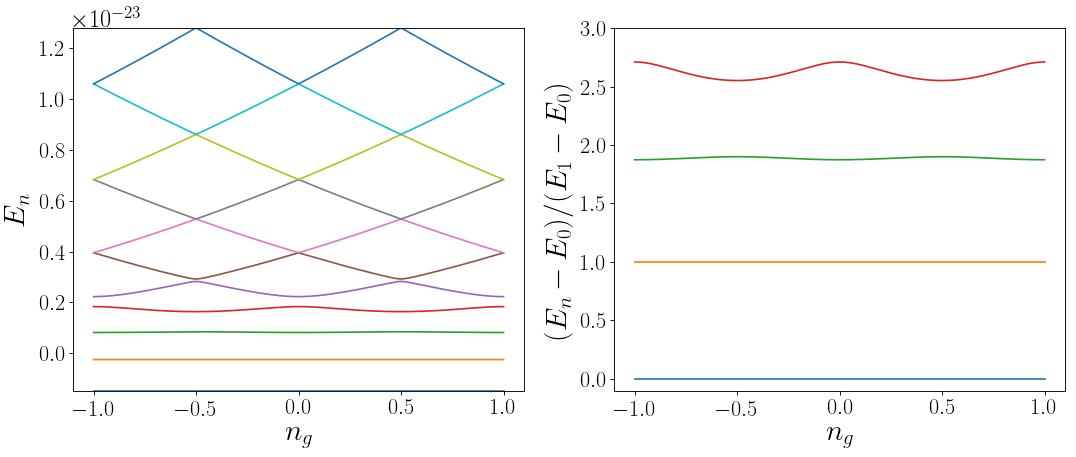

In [55]:
figEn, axes = plot_energies(ng_vec, energies, ymax=(np.max(energies[:,N]), 3));

In [56]:
#figEn.savefig('energy_spec_EJ20.png', dpi = 200, bbox_to_anchor = 'tight')

In [57]:
omega_q = 2.*np.pi*Ec*DeltaEm(1,EJ/Ec)/h

In [58]:
print 'qubit frequency: fq = {} GHz'.format(omega_q/(2.*np.pi)*10**-9)

qubit frequency: fq = 1.85401354109 GHz


In [59]:
LJ = phi_0**2./(4.*np.pi**2.*EJ)

In [60]:
print 'qubit inductance LJ = {} nH'.format(LJ*10**9)

qubit inductance LJ = 51.3529487631 nH


### deep Transmon regime

In [61]:
energies2 = array([hamiltonian(Ec, EJ2, N, ng).eigenenergies() for ng in ng_vec])

In [62]:
print 'e_min (EJ = {}) = {}'.format(EJ2, np.min(energies2[:,0]))

e_min (EJ = 6.29696491931e-23) = -5.9351836106e-23


In [63]:
EJ2/Ec

597.11106616767972

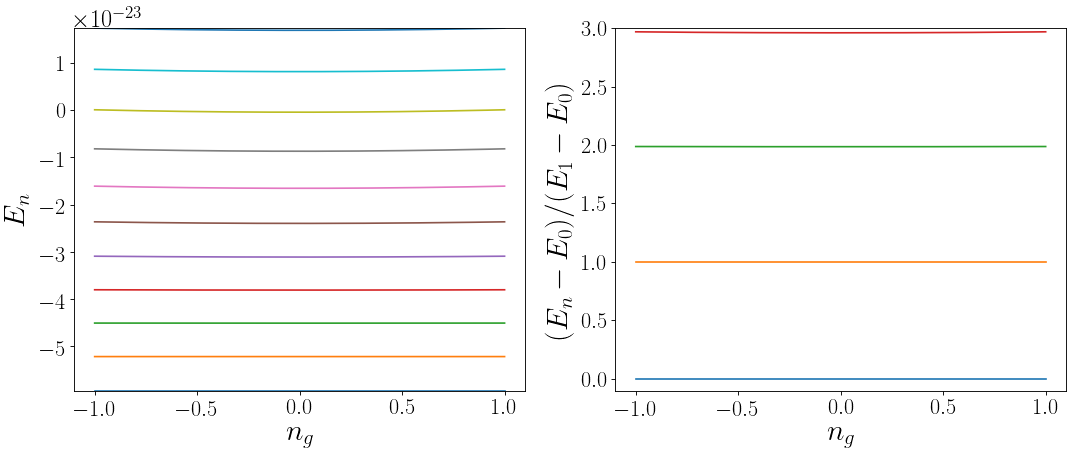

In [64]:
figEn2, axes = plot_energies(ng_vec, energies2, ymax=(np.max(energies2[:,N]), 3));

In [65]:
#figEn2.savefig('energy_spec_EJ600.png', dpi = 200, bbox_to_anchor = 'tight')

### Anharmonicity:

In [66]:
EJEC = np.linspace(0.5,140,100)

In [67]:
def ham_ECEJ(Ec, EJEC, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = Ec*(np.diag(4. * (np.arange(-N,N+1)-ng)**2) + 0.5 * EJEC * (np.diag(-np.ones(2*N), 1) + 
                                                               np.diag(-np.ones(2*N), -1)))
    return Qobj(m)

In [68]:
def alpha(E12,E01):
    '''Qubit absolute anharmonicity'''
    return np.array(E12-E01)

In [69]:
def alpha_Ec(Ec, EJEC, N):
    '''absolute anharmonicity charge Qubit with charging energy Ec
    for various ratios EJ / EC
    N determines the dimensions of the Hilbert space '''
    energies_EJEC = np.array([ham_ECEJ(Ec,E,N,ng = 0.5).eigenenergies() for E in EJEC])
    E12 = energies_EJEC[:,2]-energies_EJEC[:,1]
    E01 = energies_EJEC[:,1]-energies_EJEC[:,0]
    return np.array(E12-E01)

In [70]:
def alpha_r(alpha, E01):
    '''relative Qubit anharmonicity'''
    return np.array(alpha/E01)

In [71]:
def alpha_r_Ec(Ec, EJEC, N):
    '''relative anharmonicity charge Qubit with charging energy Ec
    for various ratios EJ / EC
    N determines the dimensions of the Hilbert space '''
    energies_EJEC = np.array([ham_ECEJ(Ec,E,N,ng = 0.5).eigenenergies() for E in EJEC])
    E12 = energies_EJEC[:,2]-energies_EJEC[:,1]
    E01 = energies_EJEC[:,1]-energies_EJEC[:,0]
    return np.array((E12-E01)/E01)

In [72]:
energies_EJEC = np.array([ham_ECEJ(Ec,E,N,ng = 0.5).eigenenergies() for E in EJEC])


In [73]:
E12 = energies_EJEC[:,2]-energies_EJEC[:,1]
E01 = energies_EJEC[:,1]-energies_EJEC[:,0]

In [74]:
s = str('Transmon limit')

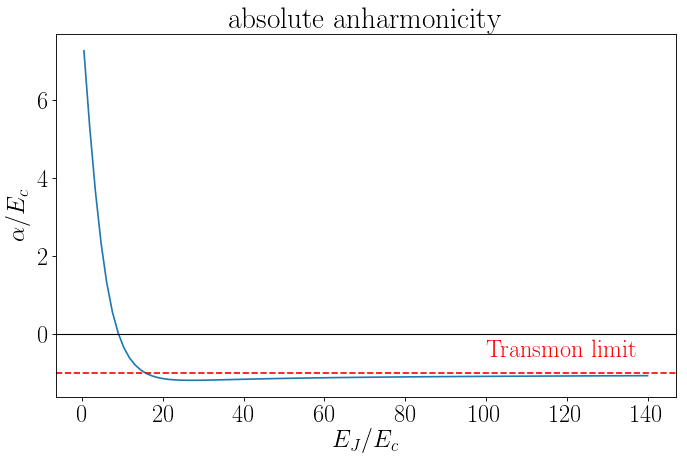

In [75]:
figalpha, axes = plt.subplots(figsize = (10,6))
axes.plot(EJEC, alpha(E12, E01)/Ec)
axes.set_xlabel(r'$E_J / E_c$')
axes.set_ylabel(r'$\alpha / E_c $')
axes.set_title('absolute anharmonicity', **hfont)
axes.axhline(0, color = 'black', lw = 1.)
axes.axhline(-1, color = 'red', ls = '--')
axes.text(100,-0.6, s, color = 'red', **hfont)

In [76]:
#figalpha.savefig('alpha_EJEC.png', dpi = 200.,  bbox_to_anchor = 'tight')

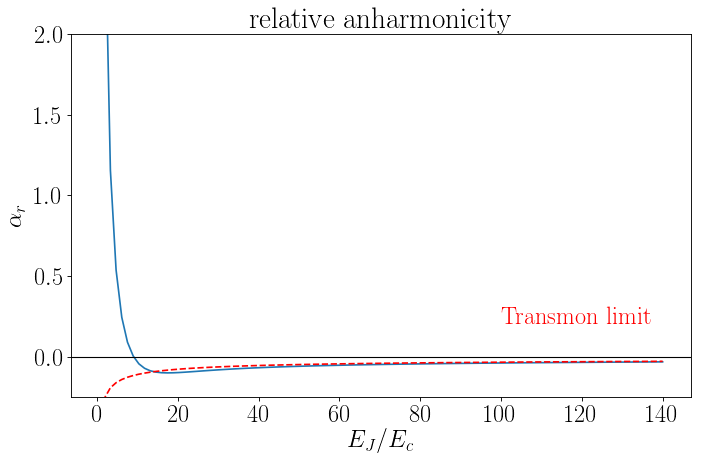

In [77]:
figalphar, axes = plt.subplots(figsize = (10,6))
axes.plot(EJEC, alpha_r(alpha(E12, E01), E01))
axes.plot(EJEC, -Ec/(np.sqrt(8.*EJEC*Ec**2.)), color ='red', ls = '--')
axes.set_xlabel(r'$E_J / E_c$')
axes.set_ylabel(r'$\alpha_r$')
axes.set_ylim([-0.25,2])
axes.set_title('relative anharmonicity')
axes.axhline(0, color = 'black', lw = 1.)
axes.text(100,0.2, s, color = 'red')

In [78]:
#figalphar.savefig('alpha_r.png', dpi = 200, bbox_to_anchor = 'tight')

### Sensitivity to charge fluctuations

In [79]:
N1 = 20

In [80]:
def charge_dispersion(Emng0, Emng05):
    '''Charge dispersion for a superconducting charge qubit'''
    return np.array(np.abs(Emng05 - Emng0))

In [81]:
def Q_disp(m,Ec, EJEC, N):
    '''Charge dispersion for the mth eigenenergy of a superconducting charge qubit with charging 
    energy Ec as a function of the ratio EJ / EC'''
    energies_ng0 = np.array([ham_ECEJ(Ec,E,N,ng = 0.0).eigenenergies() for E in EJEC])
    energies_ng05 = np.array([ham_ECEJ(Ec,E,N,ng = 0.5).eigenenergies() for E in EJEC])
    
    return np.array(energies_ng05[:,m]-energies_ng0[:,m])

In [82]:
def faculty(m):
    '''returns the faculty of a given 
    integer number m'''
    fac = 1.
    for i in range(m):
        fac *= (i+1)
    return fac

In [83]:
def epsilon_m(m, EJEC, Ec):
    '''Approximation for the charge dispersion of a charge qubit'''
    return np.array((-1.)**m*Ec*2.**(4.*m+5)/faculty(m) * np.sqrt(2/np.pi) * (EJEC/2.)**(m/2.+3/4.)*np.exp(-np.sqrt(8.*EJEC)))

In [84]:
energies_ng0 = np.array([ham_ECEJ(Ec,E,N1,ng = 0.0).eigenenergies() for E in EJEC])

In [85]:
energies_ng05 = np.array([ham_ECEJ(Ec,E,N1,ng = 0.5).eigenenergies() for E in EJEC])

In [86]:
axes.legend?

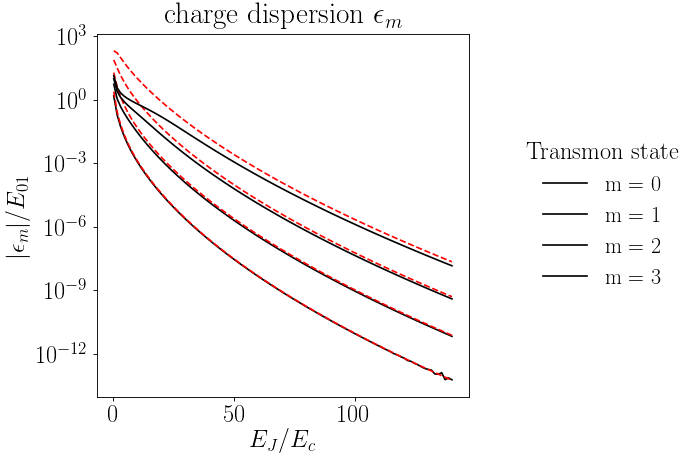

In [87]:
figQsens, axes = plt.subplots(figsize = (6,6))
for i in range(4):
    axes.plot(EJEC, charge_dispersion(energies_ng0[:,i], energies_ng05[:,i])/E01, label = 'm = {}'.format(i), color = 'black')
    axes.plot(EJEC, np.abs(epsilon_m(i, EJEC, Ec))/E01, color = 'red', ls = '--')
axes.set_yscale('log')
axes.set_xlabel(r'$E_J / E_c$')
axes.set_ylabel(r'$|\epsilon_m|/E_{01}$')
axes.set_title('charge dispersion $\epsilon_m$ ')
axes.legend(loc = 'center left', bbox_to_anchor = (1.1,0.5), ncol = 1, fontsize =20, frameon = False, title = 'Transmon state')



In [88]:
#figQsens.savefig('Q_sensitivity.png', dpi = 200, bbox_to_anchor = 'tight')

In [89]:
def omega_qubit(Ec, EJEC):
    try:
        return np.array([(EmTM(1., Ec, E*Ec) - EmTM(0., Ec, E*Ec))/hbar for E in EJEC])
    except:
        return (EmTM(1., Ec, EJEC*Ec) - EmTM(0., Ec, EJEC*Ec))/hbar

In [90]:
def LJ_qubit(Ec,wq):
    '''Josephson inductance calculated from the charging energy and 
    the qubit frequency.'''
    C = e**2. / (2.*Ec)
    return 1. / (C*wq**2.)

In [91]:
C01 = 50*10**-15.
Ec01 = e**2./(2.*C01)

C02 = 200*10**-15
Ec02 = e**2./(2.*C02)

(0, 100)

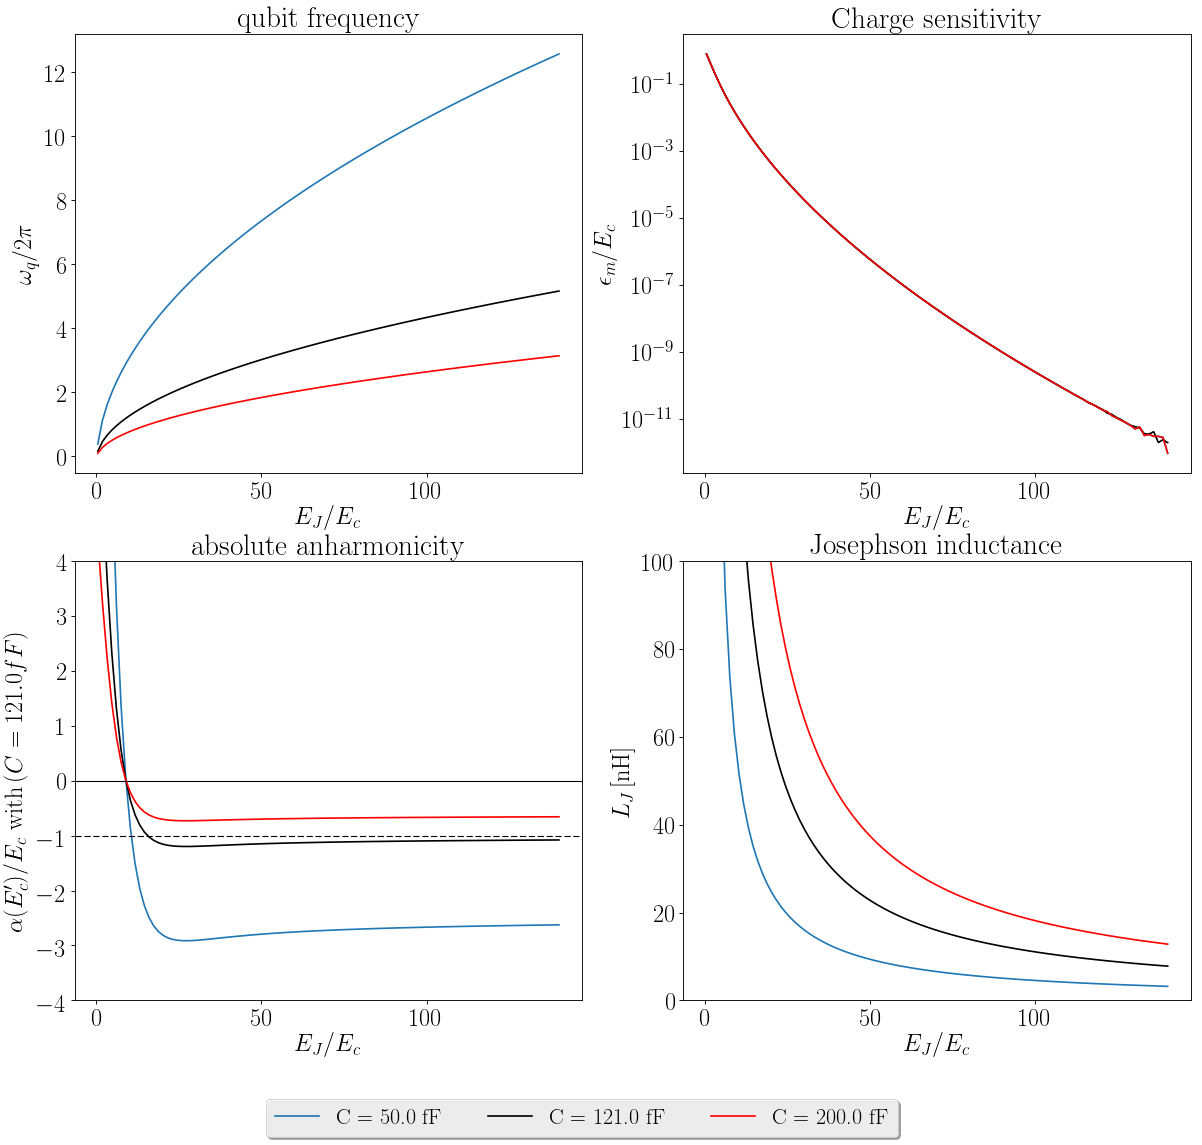

In [92]:
figQOmega, axes = plt.subplots(2,2, figsize = (18,16))
axes[0,0].plot(EJEC, omega_qubit(Ec01, EJEC)/(2.*np.pi)*10**-9, label = 'C = {} fF'.format(trunc(C01*10**15),4))
axes[0,0].plot(EJEC, omega_qubit(Ec, EJEC)/(2.*np.pi)*10**-9, label = 'C = {} fF'.format(trunc(C*10**15),4), color = 'black')
axes[0,0].plot(EJEC, omega_qubit(Ec02, EJEC)/(2.*np.pi)*10**-9, label = 'C = {} fF'.format(trunc(C02*10**15),4), color = 'red')
axes[0,0].set_xlabel(r'$E_J / E_c$')
axes[0,0].set_ylabel(r'$\omega_q / 2 \pi$')
axes[0,0].legend(loc = 'upper center', bbox_to_anchor = (1.0,-1.4), ncol = 3,  fontsize = ticksize)
axes[0,0].set_title(r'qubit frequency')
#axes[0].legend( fontsize = ticksize)

axes[0,1].plot(EJEC, Q_disp(0,Ec01,EJEC,N1)/Ec01)
axes[0,1].plot(EJEC, Q_disp(0,Ec,EJEC,N1)/Ec, color = 'black')
axes[0,1].plot(EJEC, Q_disp(0,Ec02,EJEC,N1)/Ec02, color = 'red')
axes[0,1].set_yscale('log')
axes[0,1].set_ylabel(r'$\epsilon_m / E_c$')
axes[0,1].set_xlabel(r'$E_J / E_c$')
axes[0,1].set_title('Charge sensitivity')


axes[1,0].plot(EJEC, alpha_Ec(Ec01, EJEC, N1)/Ec)
axes[1,0].plot(EJEC, alpha_Ec(Ec, EJEC, N1)/Ec, color = 'black')
axes[1,0].plot(EJEC, alpha_Ec(Ec02, EJEC, N1)/Ec, color = 'red')
axes[1,0].set_xlabel(r'$E_J / E_c$')
axes[1,0].set_ylabel(r'$\alpha (E_c^\prime) / E_c\,\,\mathrm{{with}}\,(C = {} fF) $'.format(trunc(C*10**15)))
axes[1,0].set_title('absolute anharmonicity', **hfont)
axes[1,0].axhline(0, color = 'black', lw = 1.)
axes[1,0].axhline(-1, color = 'black', lw = 1., ls = '--')
axes[1,0].set_ylim([-4., 4])

axes[1,1].plot(EJEC, LJ_qubit(Ec01,omega_qubit(Ec01, EJEC))*10**9)
axes[1,1].plot(EJEC, LJ_qubit(Ec,omega_qubit(Ec, EJEC))*10**9, color ='black')
axes[1,1].plot(EJEC, LJ_qubit(Ec02,omega_qubit(Ec02, EJEC))*10**9, color ='red')
axes[1,1].set_xlabel(r'$E_J / E_c$')
axes[1,1].set_ylabel(r'$L_J\,\mathrm{[nH]} $')
axes[1,1].set_title('Josephson inductance', **hfont)
axes[1,1].set_ylim([0, 100])

In [93]:
#figQOmega.savefig('Transmon_C1C2C3.png', dpi = 200., bbox_to_anchor = 'tight')

In [94]:
def delta_omega(Ec, EJEC, a, p = True):
    wq = omega_qubit(Ec, EJEC)     #qubit frequency; Ec:charging energy; EJEC: ratio EJ/EC
    try:
        L = np.array([LJ_qubit(Ec,w) for w in wq])
    except:
        L = LJ_qubit(Ec, wq)     #qubit's kinetic inductance
    deltaL = a/2.*L              #change in the kinetic inductance due to the molecule
    L_plus = L+deltaL
    L_minus = L-deltaL
    try:
        EJ_plus = np.array([(phi_0/(2.*np.pi))**2./Li for Li in L_plus])
        EJ_minus = np.array([(phi_0/(2.*np.pi))**2./Li for Li in L_minus])
    
    except:
        EJ_plus = (phi_0/(2.*np.pi))**2./L_plus                #EJ for spin up
        EJ_minus = (phi_0/(2.*np.pi))**2./L_minus              #EJ for spin down
    
    if p == True:
        print 'fq = {} GHz'.format(wq/(2.*np.pi*10**9))
        print 'L = {} nH'.format(L*10**9)
        print 'L_plus = {} nH'.format(L_plus*10**9)
        print 'L_minus = {} nH'.format(L_minus*10**9)
        print 'deltaL = {} pH'.format(deltaL*10**12)
        
        print 'delta E = {} GHz'.format((EJ_plus-EJ_minus)/h*10**-9)

    try:
        deltaw = np.array([Ec*(DeltaEm(1, EJ_plus[i]/Ec) - DeltaEm(1,EJ_minus[i]/Ec))/hbar for i in range(len(L))])
    except:
        deltaw = np.array(Ec*(DeltaEm(1, EJ_plus/Ec) - DeltaEm(1,EJ_minus/Ec))/hbar)  #frequency difference due to spin
    
    return np.abs(deltaw)
    
    
    

In [95]:
delta_omega(Ec, 1000., 0.01)/omega_qubit(Ec, 1000.)

fq = 14.0760959253 GHz
L = 1.05041568217 nH
L_plus = 1.05566776058 nH
L_minus = 1.04516360376 nH
deltaL = 5.25207841085 pH
delta E = -1.55619915215 GHz


0.0050000781261268857

In [96]:
dw = delta_omega(Ec, EJEC, 0.01, p = False)/10**6

In [97]:
dw.shape

(100L,)

In [98]:
EJEC01 = np.linspace(1.,1000,100)

In [99]:
(delta_omega(Ec, EJEC01, 0.01, p = False)/(omega_qubit(Ec, EJEC01)))[0]

0.0050000781261268206

In [100]:
pp = 10**-7  #procentive change in qubit inductance

C:\Program Files\Anaconda2\envs\Qutip_env\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(0, 1e-07)

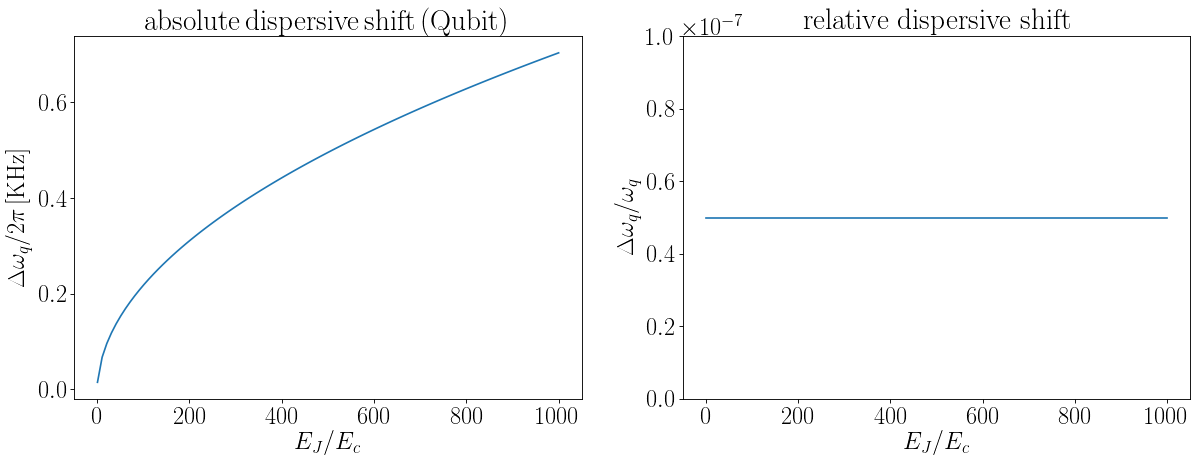

In [101]:
k = 3

figfq, axes = plt.subplots(1,2,figsize = (18,6))
axes[0].plot(EJEC01, delta_omega(Ec, EJEC01, pp, p = False)/(2.*np.pi*10**k))
axes[0].legend(fontsize = ticksize)
axes[0].set_title(r'$\mathrm{{absolute\,dispersive\,shift\,(Qubit)}}$')
axes[0].set_xlabel(r'$E_J / E_c$')
axes[1].set_xlabel(r'$E_J / E_c$')

if k == 3:
    axes[0].set_ylabel(r'$\Delta \omega_q / 2 \pi\,\mathrm{[KHz]}$')
if k == 6:
    axes[0].set_ylabel(r'$\Delta \omega_q / 2 \pi\,\mathrm{[MHz]}$')
axes[1].set_ylabel(r'$\Delta \omega_q / \omega_q$')
axes[1].set_title(r'relative dispersive shift')
axes[1].plot(EJEC01, delta_omega(Ec, EJEC01, pp, p = False)/(omega_qubit(Ec, EJEC01)))
axes[1].set_ylim([0,pp])
#axes[1].legend(fontsize = ticksize)


In [102]:
print '{}'.format(1./9-1./11)
print '{}'.format(1./90 - 1./110)

0.020202020202
0.0020202020202


## Photon number eigenbase

In [103]:
def Kerr_hamilton(w,K, N):
    '''Harmonic oscialltor (frequency w) with Kerr non-linearity K
    in the photon number eigenbase'''
    a = destroy(N)
    n = num(N)
    
    H = w * n + 0.5*K * a.dag()* a.dag() * a * a
    
    return Qobj(H)

In [104]:
def Kerr_hamilton_SO(w,K, EJ,  N):
    '''Harmonic oscialltor (frequency w) with Kerr non-linearity K
    in the photon number eigenbase'''
    a = destroy(N)
    n = num(N)
    
    H = w * n + 0.5*K * a.dag()* a.dag() * a * a + (0.5*np.abs(K))**(3./2.) * np.sqrt(hbar*6./(20.*EJ)) * a.dag() * a.dag() * a.dag() * a * a * a 
    
    return Qobj(H)

In [105]:
def Ham_OC(w,N):
    n = num(N)
    H_OC = hbar * w * n + 0.5
    return H_OC

In [106]:
omega_q*10**-9

11.649110640673518

In [107]:
K = selfK(1.,1.,Ec)
print 'K11 = {} MHz'.format(K*10**-6)

K11 = -666.666666667 MHz


In [108]:
NFock = 3

In [109]:
H_Kerr = Kerr_hamilton(omega_q, K, NFock)

In [110]:
#### Kerr nonlinearity equal to the charging energy (transmon limit)
Kerr_energies = np.array([Kerr_hamilton((EmTM(1., Ec, E*Ec)-EmTM(0.,Ec,E*Ec))/hbar,-Ec/hbar,NFock).eigenenergies() for E in EJEC])

#### higher order non-linearity
Kerr_energies_SO = np.array([Kerr_hamilton_SO((EmTM(1., Ec, E*Ec)-EmTM(0.,Ec,E*Ec))/hbar,-Ec/hbar,E*Ec,NFock).eigenenergies() for E in EJEC])


In [111]:
'''
#### Kerr nonlinearity equal to the charging energy (transmon limit)
Kerr_energies = np.array([Kerr_hamilton((EmTM(1., Ec, E*Ec)-EmTM(0.,Ec,E*Ec))/hbar,-(2./3.)*Ec/hbar,NFock).eigenenergies() for E in EJEC])

#### higher order non-linearity
Kerr_energies_SO = np.array([Kerr_hamilton_SO((EmTM(1., Ec, E*Ec)-EmTM(0.,Ec,E*Ec))/hbar,-(2./3.)*Ec/hbar,E*Ec,NFock).eigenenergies() for E in EJEC])
'''

'\n#### Kerr nonlinearity equal to the charging energy (transmon limit)\nKerr_energies = np.array([Kerr_hamilton((EmTM(1., Ec, E*Ec)-EmTM(0.,Ec,E*Ec))/hbar,-(2./3.)*Ec/hbar,NFock).eigenenergies() for E in EJEC])\n\n#### higher order non-linearity\nKerr_energies_SO = np.array([Kerr_hamilton_SO((EmTM(1., Ec, E*Ec)-EmTM(0.,Ec,E*Ec))/hbar,-(2./3.)*Ec/hbar,E*Ec,NFock).eigenenergies() for E in EJEC])\n'

In [112]:
#Kerr_energies = np.array([Kerr_hamilton((EmTM(1., Ec, E*Ec)-EmTM(0.,Ec,E*Ec))/hbar,selfK(4.,4.,Ec),NFock).eigenenergies() for E in EJEC])

In [113]:
Ec

1.0545718001391126e-25

In [114]:
f01 = (EmTM(1., Ec, EJEC*Ec)-EmTM(0., Ec, EJEC*Ec))/h
f12 = (EmTM(2., Ec, EJEC*Ec)-EmTM(1., Ec, EJEC*Ec))/h

f01_Kerr = (np.array(Kerr_energies[:,1]-Kerr_energies[:,0]))/(2.*np.pi)
f12_Kerr = (np.array(Kerr_energies[:,2]-Kerr_energies[:,1]))/(2.*np.pi)

f01_Kerr_SO = (np.array(Kerr_energies_SO[:,1]-Kerr_energies_SO[:,0]))/(2.*np.pi)
f12_Kerr_SO = (np.array(Kerr_energies_SO[:,2]-Kerr_energies_SO[:,1]))/(2.*np.pi)

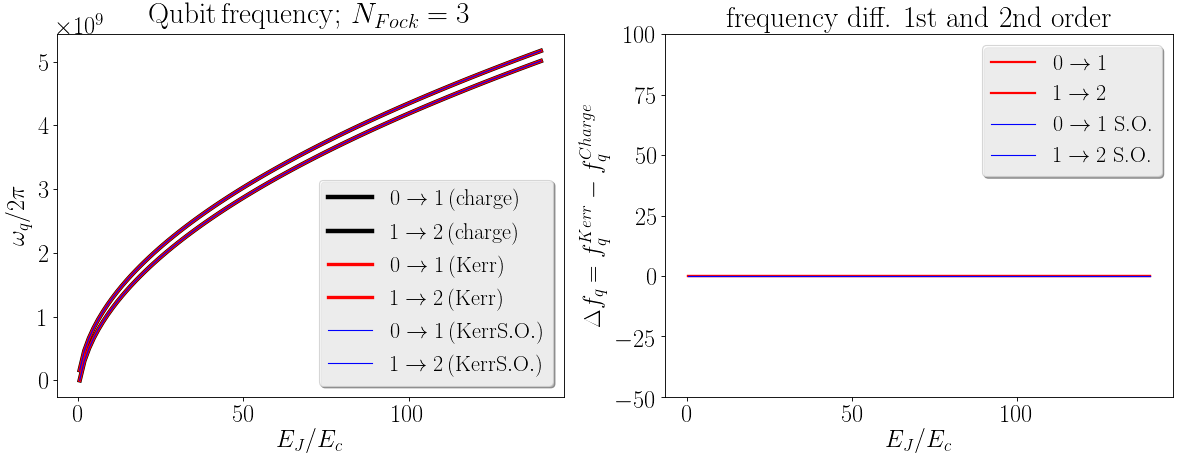

In [115]:
figfq, axes = plt.subplots(1,2,figsize = (18,6))
axes[0].plot(EJEC, f01 , color = 'black', lw = 4., label = r'$0 \rightarrow 1\,\mathrm{(charge)}$')
axes[0].plot(EJEC, f12 , color = 'black', lw = 4., label = r'$1 \rightarrow 2\,\mathrm{(charge)}$')
axes[0].plot(EJEC, f01_Kerr, color = 'red', lw = 3., label = r'$0 \rightarrow 1\,\mathrm{(Kerr)}$')
axes[0].plot(EJEC, f12_Kerr, color = 'red', lw = 3., label = r'$1 \rightarrow 2\,\mathrm{(Kerr)}$')
axes[0].plot(EJEC, f01_Kerr_SO, color = 'blue', lw = 1., label = r'$0 \rightarrow 1\,\mathrm{(Kerr S.O.)}$')
axes[0].plot(EJEC, f12_Kerr_SO, color = 'blue', lw = 1., label = r'$1 \rightarrow 2\,\mathrm{(Kerr S.O.)}$')
axes[0].legend(fontsize = ticksize)
axes[0].set_title(r'$\mathrm{{Qubit\,frequency}};\,N_{{Fock}}={}$'.format(NFock))
axes[0].set_xlabel(r'$E_J / E_c$')
axes[1].set_xlabel(r'$E_J / E_c$')

axes[0].set_ylabel(r'$\omega_q / 2 \pi$')
axes[1].set_ylabel(r'$\Delta f_q = f_q^{Kerr} - f_q^{Charge}$')
axes[1].set_title(r'frequency diff. 1st and 2nd order')
axes[1].plot(EJEC, (f01_Kerr - f01)*10**-6, lw = 2., label = r'$0 \rightarrow 1$', color = 'red')
axes[1].plot(EJEC, (f12_Kerr - f12)*10**-6, lw = 2., label = r'$1 \rightarrow 2$', color = 'red')
axes[1].plot(EJEC, (f01_Kerr_SO - f01)*10**-6, lw = 1., label = r'$0 \rightarrow 1$ S.O.', color = 'blue')
axes[1].plot(EJEC, (f12_Kerr_SO - f12)*10**-6, lw = 1., label = r'$1 \rightarrow 2$ S.O.', color = 'blue')
axes[1].set_ylim([-50,100])
axes[1].legend(fontsize = ticksize)

In [116]:
#figfq.savefig('qubit_freq_Kerr_Charge_NFock=30.png', dpi = 200., bbox_to_anchor = 'tight')

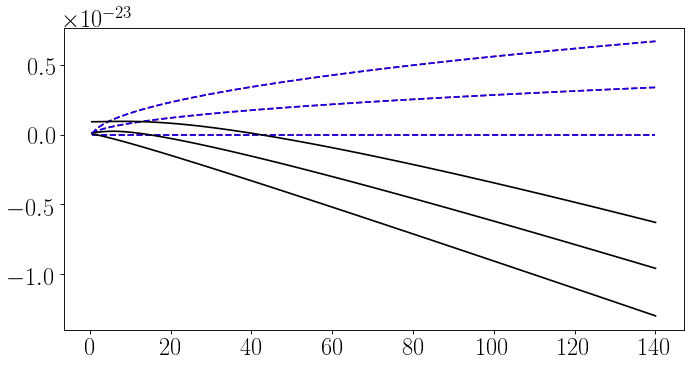

In [117]:
for i in range(3):
    plt.plot(EJEC, hbar*Kerr_energies[:,i], color ='red', ls= '--')
    plt.plot(EJEC, hbar*Kerr_energies_SO[:,i], color ='blue', ls= '--')
    plt.plot(EJEC, energies_EJEC[:,i], color = 'black')